In [78]:
# Importamos mersenne twister de nuestra implementacion
from mersenne_twister import MersenneTwister

---

# Ejercicio 1 

Un servidor recibe solicitudes las cuales son procesadas de una por vez en el orden de llegada (política FIFO).\
Se determinó que en 10 milisegundos existe una probabilidad p = 1/40 que llegue una nueva solicitud y q = 1/30 que una solicitud termine de ser procesada y deje el sistema.\
Se desea estudiar la cantidad de solicitudes en el servidor considerando tanto las que están en cola esperando ser 
procesadas como la solicitud que está siendo procesada. 
 
a. Determine la matriz de transición de estados explicando cómo se obtiene la misma.\
b. Simule, utilizando el generador de números al azar desarrollado en el tp 1, la evolución del sistema a lo largo de 
1.500 segundos. Suponga que el servidor comienza sin estar procesando solicitudes.\
c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.\
d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.\
e. Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

---

### a. Determine la matriz de transición de estados explicando cómo se obtiene la misma.

Los eventos que pueden ocurrir son:
- Llega una nueva solicitud. Con probabilidad $p = 1/40$.
- Se termina de procesar una solicitud. Con probabilidad $q = 1/30$.
- No ocurre ningún evento. Con probabilidad $r = \overline{pq} + p\overline{q}$.

Si bien podríamos haber pensado en posibilidades de que llegue una nueva solicitud y se procese alguna en el mismo lapso de tiempo, pero como el enunciado no es claro respecto a esto, lo descartamos.

A continuación presentamos la matriz de transición de estados. En la misma, las filas representan el estado actual del sistema y las columnas el estado siguiente.\
Por ejemplo: 
* La celda (0, 0) representa la probabilidad de que el sistema se mantenga en el estado 0 (sin solicitudes).
* La celda (0, 1) representa la probabilidad de que el sistema pase del estado 0 (sin solicitudes) al estado 1 (con una solicitud en proceso). 
* La celda (1, 2) representa la probabilidad de que el sistema pase del estado 1 (con una solicitud en proceso) al estado 2 (con una solicitud en proceso y una en cola).
* La celda (2, 1) representa la probabilidad de que el sistema pase del estado 2 (con una solicitud en proceso y una en cola) al estado 1 (con una solicitud en proceso).

\begin{bmatrix}

    \overline{p} & p & 0 & 0 & 0 & ... & 0 & 0 & 0 \\
    q\overline{p} & r & p\overline{q} & 0 & ... & 0 & 0 & 0 \\
    0 & q\overline{p} & r & p\overline{q} & 0 & ... & 0 & 0 & 0 \\
    ... & ... & ... & ... & ... & ... & ... & ... & ... \\
    0 & 0 & 0 & 0 & 0 & ... & q\overline{p} & r & p\overline{q} \\
    0 & 0 & 0 & 0 & 0 & ... & 0 & q & \overline{q} \\   
     
\end{bmatrix}


Para la matriz necesitamos conocer la cantidad de estados posibles. Es decir, la cantidad máxima de estados posibles viene dada por el tiempo de simulación (1500 segundos) dividido por el tiempo que tarda en ocurrir un evento (10 milisegundos).\
Por lo tanto, la cantidad de estados posibles es $1500 / 0.01 = 150000$.

In [79]:
import scipy.sparse as sp
import numpy as np

# Tamaño de la matriz y probabilidades de transición
n = 150000
p = 1 / 40
q = 1 / 30
r = 1 - (q*(1-p) + p*(1-q))

# Crear una matriz dispersa, inicialmente llena de ceros
matrix = sp.lil_matrix((n, n), dtype=np.float64)

for i in range(1, n):
    matrix[i, i] = r  # Valores en la diagonal principal
    matrix[i - 1, i] = p * (1 - q)  # Valores en la diagonal superior
    matrix[i, i - 1] = q * (1 - p)  # Valores en la diagonal inferior
    
matrix[0, 0] = 1 - p
matrix[0, 1] = p
matrix[n - 1, n - 2] = q
matrix[n - 1, n - 1] = 1 - q

matrix = matrix.tocsr()

### b. Simule, utilizando el generador de números al azar desarrollado en el tp 1, la evolución del sistema a lo largo de 1.500 segundos. Suponga que el servidor comienza sin estar procesando solicitudes.

In [80]:
mer_twis = MersenneTwister(0)

In [81]:
def simular_solicitudes(tiempo_simulacion, step):
    cantidad_en_cola = 0
    cantidad_procesados = 0
    solicitudes_por_tiempo = []
    cant_por_estado = {}

    for _ in range(0, tiempo_simulacion, step):
        probabilidad = mer_twis.uniform()

        if cantidad_en_cola == 0:
            if probabilidad < p:
                cantidad_en_cola += 1
        else:
            if probabilidad < q*(1-p):
                cantidad_en_cola -= 1
                cantidad_procesados += 1

            elif probabilidad < q*(1-p) + p*(1-q):
                cantidad_en_cola += 1

            else:
                cantidad_procesados += 1

        # plasmamos el resultado en solicitudes_por_tiempo
        solicitudes_por_tiempo.append(cantidad_en_cola)
        if cantidad_en_cola in cant_por_estado:
            cant_por_estado[cantidad_en_cola] += 1
        else:
            cant_por_estado[cantidad_en_cola] = 1

    return (
        cantidad_procesados,
        cantidad_en_cola,
        solicitudes_por_tiempo,
        cant_por_estado,
    )

In [82]:
(
    cantidad_procesados,
    cantidad_en_cola,
    solicitudes_por_tiempo,
    cant_por_estado,
) = simular_solicitudes(150000, 1)

print(f"Procesados: {cantidad_procesados}")
print(f"En cola: {cantidad_en_cola}")

Procesados: 112730
En cola: 2


### c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.

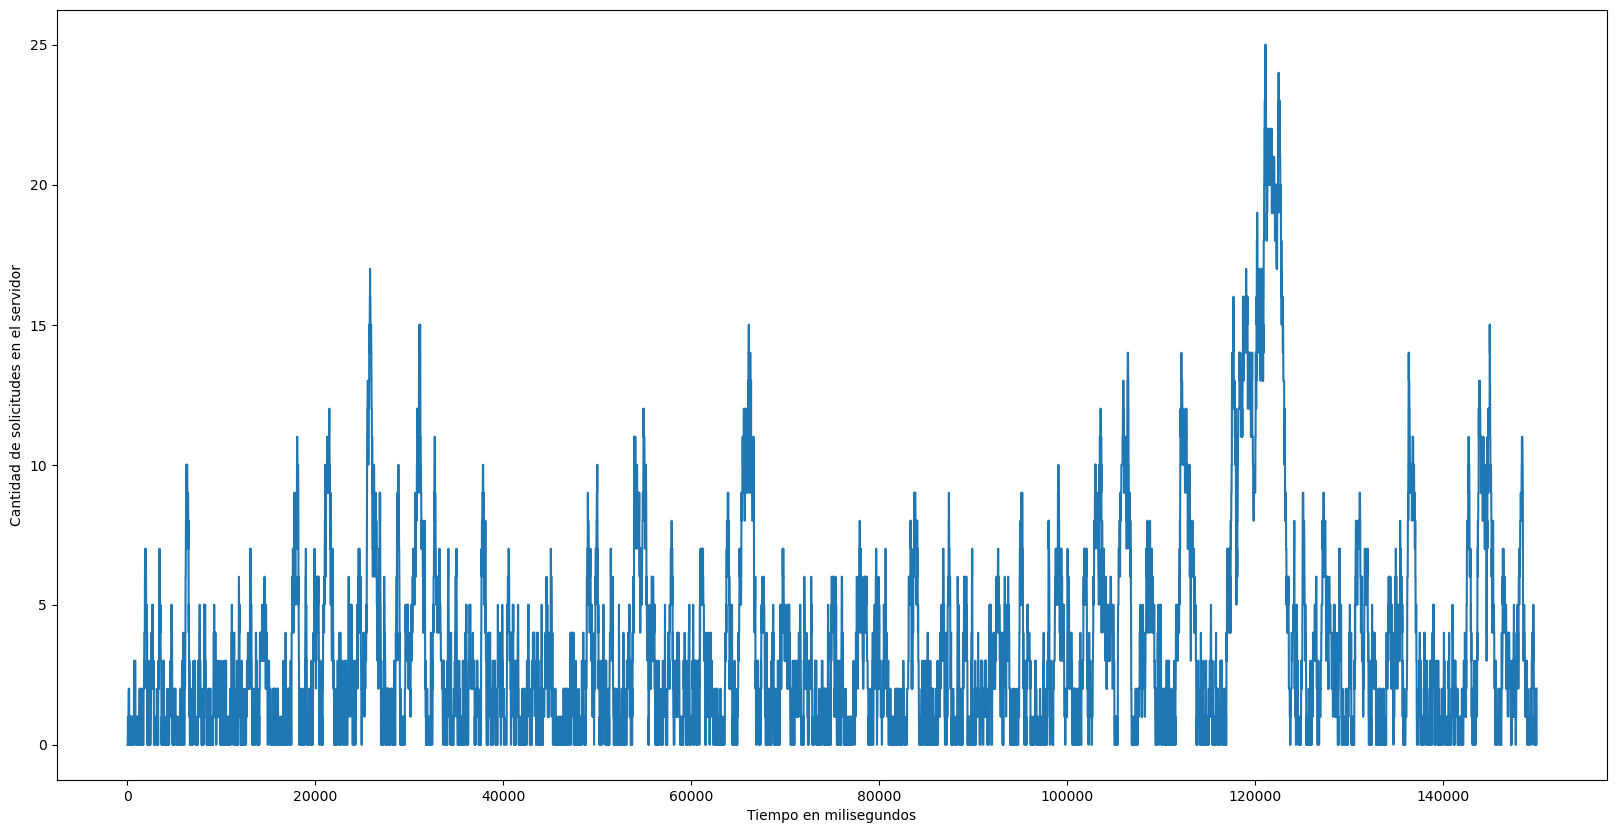

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(solicitudes_por_tiempo)
plt.xlabel("Tiempo en milisegundos")
plt.ylabel("Cantidad de solicitudes en el servidor")
plt.show()

### d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.

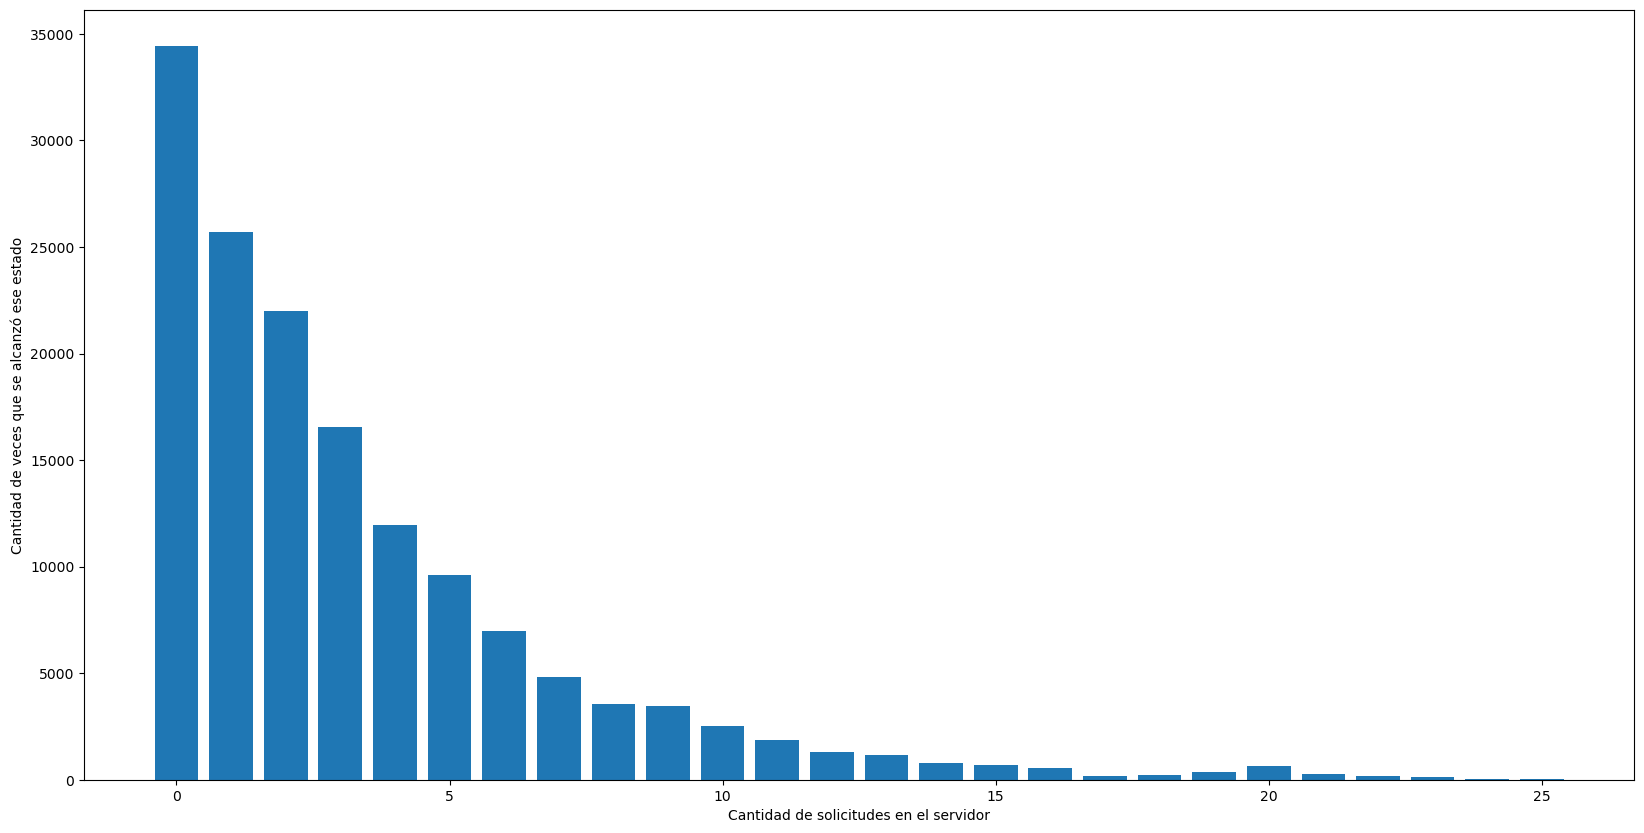

In [84]:
plt.figure(figsize=(20, 10))
plt.bar(cant_por_estado.keys(), cant_por_estado.values())
plt.xlabel("Cantidad de solicitudes en el servidor")
plt.ylabel("Cantidad de veces que se alcanzó ese estado")
plt.show()

In [85]:
cant_tiempo_sin_procesar = cant_por_estado[0]

cant_tiempo_procesado = sum(cant_por_estado.values()) - cant_tiempo_sin_procesar

print(f"Tiempo sin procesar: {cant_tiempo_sin_procesar} milisegundos")

Tiempo sin procesar: 34416 milisegundos
